In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/z-am-expert-av2019/train.csv
/kaggle/input/z-am-expert-av2019/sample_submission_Byiv0dS.csv
/kaggle/input/z-am-expert-av2019/coupon_item_mapping.csv
/kaggle/input/z-am-expert-av2019/test_QyjYwdj.csv
/kaggle/input/z-am-expert-av2019/campaign_data.csv
/kaggle/input/z-am-expert-av2019/item_data.csv
/kaggle/input/z-am-expert-av2019/customer_transaction_data.csv
/kaggle/input/z-am-expert-av2019/customer_demographics.csv
/kaggle/input/av-amexpert-2019-trans-calc-agg/trans_calc_df.csv


In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold
import matplotlib.pyplot as plt, seaborn as sns
from sklearn import preprocessing, metrics
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy.sparse import csr_matrix, coo_matrix
from scipy.sparse.linalg import svds
import time
import os
import gc
gc.collect()
pd.options.display.max_columns=1000
%matplotlib inline

In [3]:
def df_profile(data_frame = None):
    #import pandas as pd, numpy as np
    #read the csv file
    d = []
    for column in data_frame.columns:
        d.append({'column_name': column,
                  'data_type': data_frame[column].dtype,
                  'total_cnt': data_frame[column].size,
                  'not_null_col_cnt': data_frame[column].count(),
                  'null_count': sum(pd.isnull(data_frame[column])),
                  'unique_count': data_frame[column].nunique(),
                  'null_by_total_cnt': sum(pd.isnull(data_frame[column]))/data_frame[column].size,
                  'unique_by_not_null_cnt': data_frame[column].nunique()/data_frame[column].count(),
                  'unique_by_total_cnt': data_frame[column].nunique()/data_frame[column].size
                 })
        
    #d 
    
    df = pd.DataFrame(d,columns=d[0].keys())
    
    return df

def z_labenc(train = None, test=None, cat_cols=None):
    cat_cols=cat_cols
    for col in cat_cols:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
        train[col] = lbl.transform(list(train[col].values.astype('str')))
        test[col] = lbl.transform(list(test[col].values.astype('str')))
        print(col)

################################################
##Calculate RMSE
def rmse(x,y): return np.sqrt(((x-y)**2).mean())

################################################
##Plot LGBM Feature Importances
def plot_lgb_imp(trainX=None,model=None,n=10,fs=(10,8)):
    sns.set(style="whitegrid")
    
    feats = {} # a dict to hold feature_name: feature_importance
    for feature, importance in zip(model.feature_name(), model.feature_importance()):
        feats[feature] = importance #add the name/value pair
    importances = pd.DataFrame.from_dict(feats, orient='index')
    
    importances.columns = ["imp"]
    importances = importances.sort_values(by='imp').tail(n)
    
    fig, ax = plt.subplots(figsize=fs)
    y_pos = np.arange(len(importances))
    ax.barh(y_pos, importances['imp'], color='blue', ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(importances.index)
    plt.show()
    
    importances = importances.sort_values(by='imp',ascending=False).tail(n)
    
    return importances

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

def plotly_bar(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.values[::-1],
        x=cnt_srs.index[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

In [4]:
def get_val_cnt(df = None, col_name = None, fs=(8,4), sort_idx=False):
    val_cnt = df[col_name].value_counts()
    
    #useful for date columns where we need data sorted according to date
    if sort_idx:
        val_cnt = df[col_name].value_counts().sort_index()
    
    print(f"Unique {col_name} count:")
    print(val_cnt)
    
    plt.figure(figsize=fs)
    sns.barplot(val_cnt.index, val_cnt.values, alpha=0.8)
    plt.ylabel('Count', fontsize=12)
    plt.xlabel(col_name, fontsize=12)
    plt.xticks(rotation='vertical')
    plt.show()

def plot_with_hue(df = None, plot_col_name = None, hue_col_name = None, fs=(8,4),df_name = "DataFrame"):
    plt.figure(figsize=fs)
    sns.countplot(data=df, x=plot_col_name, hue=hue_col_name, alpha=0.8)
    plt.xticks(rotation='vertical')
    plt.xlabel(plot_col_name)
    plt.ylabel("Count")
    plt.title(plot_col_name + " in "+ df_name)
    plt.show()

def get_common_cnt(df1,df2,col_name):
    return len(set(df1[col_name]).intersection(set(df2[col_name])))

def df_profile(data_frame = None):
    #import pandas as pd, numpy as np
    #read the csv file
    d = []
    for column in data_frame.columns:
        d.append({'column_name': column,
                  'data_type': data_frame[column].dtype,
                  'total_cnt': data_frame[column].size,
                  'not_null_col_cnt': data_frame[column].count(),
                  'null_count': sum(pd.isnull(data_frame[column])),
                  'unique_count': data_frame[column].nunique(),
                  'null_by_total_cnt': sum(pd.isnull(data_frame[column]))/data_frame[column].size,
                  'unique_by_not_null_cnt': data_frame[column].nunique()/data_frame[column].count(),
                  'unique_by_total_cnt': data_frame[column].nunique()/data_frame[column].size
                 })
        
    #d 
    
    df = pd.DataFrame(d,columns=d[0].keys())
    
    return df

def train_test_cat_dist(train_df,test_df,col_list):
    #used for distribution comparison of categorical variable between train and test
    #col_list = list of column whose distribution needs to be displayed
    #calls get_val_cnt
    for colname in col_list:
        print(colname)
        print("---------------------")
        print("Training Set")
        get_val_cnt(train_df,colname)
        print("Test Set")
        get_val_cnt(test_df,colname)
        print("")
        print("======================")

In [5]:
path='/kaggle/input/z-am-expert-av2019/'
TARGET_VAR='redemption_status'

In [6]:
%%time
train = pd.read_csv(path+'train.csv')
campaign= pd.read_csv(path+'campaign_data.csv')
coupon_item= pd.read_csv(path+'coupon_item_mapping.csv')
customer_demographics= pd.read_csv(path+'customer_demographics.csv')
customer_transaction= pd.read_csv(path+'customer_transaction_data.csv',parse_dates=['date'])
item= pd.read_csv(path+'item_data.csv')
test = pd.read_csv(path+'test_QyjYwdj.csv')


CPU times: user 1.26 s, sys: 228 ms, total: 1.48 s
Wall time: 1.51 s


In [7]:
### There are duplicates in train !!!
print(train.shape)
train = train.drop_duplicates(subset=["customer_id","campaign_id","coupon_id"])
print(train.shape)

(78369, 5)
(78357, 5)


In [8]:
train.name="train"
campaign.name="campaign"
coupon_item.name="coupon_item"
customer_demographics.name="customer_demographics"
customer_transaction.name="customer_transaction"
item.name="item"
test.name="test"

In [9]:
def runLGB(train_X, train_y, test_X, test_y=None,categorical_feature='auto'): 
    params = {}
    params["objective"] = "binary"
    params['metric'] = 'auc'
    params["max_depth"] = 12 # -1 means no limit
    #params['num_leaves'] = 70   # we should let it be smaller than 2^(max_depth). Around 0.7 to 0.8
    params["min_data_in_leaf"] = 100 #Aka min_data.  constraints: min_data_in_leaf >= 0
    #params["max_bin"] = 255 #default = 255, type = int, constraints: max_bin > 1. small number of bins may reduce training accuracy but may increase general power (deal with over-fitting)
    params["learning_rate"] = 0.01
    params["subsample"] = 0.7  # Subsample ratio of the training instance. Aka bagging_fraction
    params["feature_fraction"] = 0.7
    params["bagging_freq"] = 5 #0 = disable bagging. To enable bagging, bagging_fraction should be set to value smaller than 1.0
    params["bagging_seed"] = 2019
    #params["min_split_gain"] = 0  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    #params["reg_alpha"] = 10  # L1 regularization term on weights
    #params["reg_lambda"] = 22  # L2 regularization term on weights
    params["verbosity"] = -1 #Aka verbose. < 0: Fatal, = 0: Error (Warning), = 1: Info, > 1: Debug
    num_rounds = 10000
    
    lgtrain = lgb.Dataset(train_X, label=train_y, categorical_feature=categorical_feature)

    if test_y is not None:
        evals_result = {}  # to record eval results for plotting
        lgtest = lgb.Dataset(test_X, label=test_y,categorical_feature=categorical_feature)
        model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgtrain,lgtest],
                          early_stopping_rounds=500,
                          evals_result=evals_result,
                          verbose_eval=500)
        
        print('Plotting metrics recorded during training...')
        ax = lgb.plot_metric(evals_result, metric=params['metric'])
        plt.show()
    else:
        lgtest = lgb.Dataset(test_X, categorical_feature=categorical_feature)
        model = lgb.train(params, lgtrain, num_rounds)

    #pred_dev =  model.predict(train_X, num_iteration=model.best_iteration)   
    #pred_test = model.predict(test_X, num_iteration=model.best_iteration)
    
    return model

In [10]:
train_df=train.copy()
test_df=test.copy()

### Join with campaign

In [11]:
campaign["start_date"] = pd.to_datetime(campaign["start_date"],format='%d/%m/%y')
campaign["end_date"] = pd.to_datetime(campaign["end_date"],format='%d/%m/%y')
campaign["campaign_duration"] = (campaign["end_date"] - campaign["start_date"]).dt.days
campaign["camp_start_month"] = campaign.start_date.dt.month
campaign["camp_start_weekofyear"] = campaign.start_date.dt.weekofyear
campaign["camp_start_yr"] = campaign.end_date.dt.year
campaign["camp_end_month"] = campaign.end_date.dt.month
campaign["camp_end_weekofyear"] = campaign.end_date.dt.weekofyear
campaign["camp_end_yr"] = campaign.end_date.dt.year
campaign.head(3)

,campaign_id,campaign_type,start_date,end_date,campaign_duration,camp_start_month,camp_start_weekofyear,camp_start_yr,camp_end_month,camp_end_weekofyear,camp_end_yr
0,24,Y,2013-10-21,2013-12-20,60,10,43,2013,12,51,2013
1,25,Y,2013-10-21,2013-11-22,32,10,43,2013,11,47,2013
2,20,Y,2013-09-07,2013-11-16,70,9,36,2013,11,46,2013


In [12]:
### cyclicity features
campaign["camp_start_weekofyear_cyc4"] = campaign["camp_start_weekofyear"]%4
campaign["camp_start_weekofyear_cyc6"] = campaign["camp_start_weekofyear"]%6
campaign["camp_start_weekofyear_cyc8"] = campaign["camp_start_weekofyear"]%8
campaign["camp_start_weekofyear_cyc12"] = campaign["camp_start_weekofyear"]%12
campaign["camp_start_weekofyear_cyc25"] = campaign["camp_start_weekofyear"]%25

campaign["camp_end_weekofyear_cyc4"] = campaign["camp_end_weekofyear"]%4
campaign["camp_end_weekofyear_cyc6"] = campaign["camp_end_weekofyear"]%6
campaign["camp_end_weekofyear_cyc8"] = campaign["camp_end_weekofyear"]%8
campaign["camp_end_weekofyear_cyc12"] = campaign["camp_end_weekofyear"]%12
campaign["camp_end_weekofyear_cyc25"] = campaign["camp_end_weekofyear"]%25

In [13]:
%%time
#campaign sequence features

campaign = campaign.sort_values(["start_date","campaign_id"])

##Previous 2 campaign
campaign["p1_camp"] = campaign["campaign_id"].shift(1)
campaign["p1_camp_start_date"] = campaign["start_date"].shift(1)
campaign["p1_camp_end_date"] = campaign["end_date"].shift(1)
campaign["p1_camp_type"] = campaign["campaign_type"].shift(1)

campaign["p2_camp"] = campaign["campaign_id"].shift(2)
campaign["p2_camp_start_date"] = campaign["start_date"].shift(2)
campaign["p2_camp_end_date"] = campaign["end_date"].shift(2)
campaign["p2_camp_type"] = campaign["campaign_type"].shift(2)

##Next 2 campaign
campaign["n1_camp"] = campaign["campaign_id"].shift(-1)
campaign["n1_camp_start_date"] = campaign["start_date"].shift(-1)
campaign["n1_camp_end_date"] = campaign["end_date"].shift(-1)
campaign["n1_camp_type"] = campaign["campaign_type"].shift(-1)

campaign["n2_camp"] = campaign["campaign_id"].shift(-2)
campaign["n2_camp_start_date"] = campaign["start_date"].shift(-2)
campaign["n2_camp_end_date"] = campaign["end_date"].shift(-2)
campaign["n2_camp_type"] = campaign["campaign_type"].shift(-2)

#gap between campaigns
campaign["time_to_n1_camp_start_stdt"] = (campaign["n1_camp_start_date"] - campaign["start_date"]).dt.days
campaign["time_to_n1_camp_start_enddt"] = (campaign["n1_camp_start_date"] - campaign["end_date"]).dt.days
campaign["time_to_n2_camp_start_stdt"] = (campaign["n2_camp_start_date"] - campaign["start_date"]).dt.days
campaign["time_to_n2_camp_start_enddt"] = (campaign["n2_camp_start_date"] - campaign["end_date"]).dt.days

campaign["time_since_p1_camp_end_stdt"] = (campaign["start_date"] - campaign["p1_camp_end_date"]).dt.days
campaign["time_since_p1_camp_end_enddt"] = (campaign["end_date"] - campaign["p1_camp_end_date"]).dt.days
campaign["time_since_p2_camp_end_stdt"] = (campaign["start_date"] - campaign["p2_camp_end_date"]).dt.days
campaign["time_since_p2_camp_end_enddt"] = (campaign["end_date"] - campaign["p2_camp_end_date"]).dt.days

#calculate overlap with previous and next campaigns
def calc_overlap(r1_stdt,r1_enddt,r2_stdt,r2_enddt):
    latest_start = max(r1_stdt, r2_stdt)
    earliest_end = min(r1_enddt, r2_enddt)
    delta = (earliest_end - latest_start).days + 1
    overlap = max(0, delta)
    return overlap

campaign["overlap_p1"] = [calc_overlap( start_date,end_date,p1_camp_start_date,p1_camp_end_date) for start_date,end_date,p1_camp_start_date,p1_camp_end_date in zip(campaign["start_date"],campaign["end_date"],campaign["p1_camp_start_date"],campaign["p1_camp_end_date"])]
campaign["overlap_p2"] = [calc_overlap( start_date,end_date,p1_camp_start_date,p1_camp_end_date) for start_date,end_date,p1_camp_start_date,p1_camp_end_date in zip(campaign["start_date"],campaign["end_date"],campaign["p2_camp_start_date"],campaign["p2_camp_end_date"])]
campaign["overlap_n1"] = [calc_overlap( start_date,end_date,p1_camp_start_date,p1_camp_end_date) for start_date,end_date,p1_camp_start_date,p1_camp_end_date in zip(campaign["start_date"],campaign["end_date"],campaign["n1_camp_start_date"],campaign["n1_camp_end_date"])]
campaign["overlap_n2"] = [calc_overlap( start_date,end_date,p1_camp_start_date,p1_camp_end_date) for start_date,end_date,p1_camp_start_date,p1_camp_end_date in zip(campaign["start_date"],campaign["end_date"],campaign["n2_camp_start_date"],campaign["n2_camp_end_date"])]

#create campaign sequence
campaign["camp_sequence"] = range(len(campaign["campaign_id"]))

#impute missing values
#Impute values
campaign["p1_camp"] = campaign["p1_camp"].fillna(99)
campaign["p1_camp_type"] = campaign["p1_camp_type"].fillna('Y')
campaign.loc[campaign["campaign_id"]==26,"p2_camp"] = 100
campaign.loc[campaign["campaign_id"]==27,"p2_camp"] = 99
campaign["p2_camp_type"] = campaign["p2_camp_type"].fillna('Y')

campaign["n1_camp"] = campaign["n1_camp"].fillna(99)
campaign["n1_camp_type"] = campaign["n1_camp_type"].fillna('Y')
campaign.loc[campaign["campaign_id"]==24,"n2_camp"] = 101
campaign.loc[campaign["campaign_id"]==25,"n2_camp"] = 102
campaign["n2_camp_type"] = campaign["n2_camp_type"].fillna('Y')

campaign["time_to_n1_camp_start_stdt"] = campaign["time_to_n1_camp_start_stdt"].fillna(campaign["time_to_n1_camp_start_stdt"].median())
campaign["time_to_n1_camp_start_enddt"] = campaign["time_to_n1_camp_start_enddt"].fillna(campaign["time_to_n1_camp_start_enddt"].median())
campaign["time_to_n2_camp_start_stdt"] = campaign["time_to_n2_camp_start_stdt"].fillna(campaign["time_to_n2_camp_start_stdt"].median())
campaign["time_to_n2_camp_start_enddt"] = campaign["time_to_n2_camp_start_enddt"].fillna(campaign["time_to_n2_camp_start_enddt"].median())

campaign["time_since_p1_camp_end_stdt"] = campaign["time_since_p1_camp_end_stdt"].fillna(campaign["time_since_p1_camp_end_stdt"].median())
campaign["time_since_p1_camp_end_enddt"] = campaign["time_since_p1_camp_end_enddt"].fillna(campaign["time_since_p1_camp_end_enddt"].median())
campaign["time_since_p2_camp_end_stdt"] = campaign["time_since_p2_camp_end_stdt"].fillna(campaign["time_since_p2_camp_end_stdt"].median())
campaign["time_since_p2_camp_end_enddt"] = campaign["time_since_p2_camp_end_enddt"].fillna(campaign["time_since_p2_camp_end_enddt"].median())

CPU times: user 80 ms, sys: 4 ms, total: 84 ms
Wall time: 73.4 ms


In [14]:
campaign.head()

,campaign_id,campaign_type,start_date,end_date,campaign_duration,camp_start_month,camp_start_weekofyear,camp_start_yr,camp_end_month,camp_end_weekofyear,camp_end_yr,camp_start_weekofyear_cyc4,camp_start_weekofyear_cyc6,camp_start_weekofyear_cyc8,camp_start_weekofyear_cyc12,camp_start_weekofyear_cyc25,camp_end_weekofyear_cyc4,camp_end_weekofyear_cyc6,camp_end_weekofyear_cyc8,camp_end_weekofyear_cyc12,camp_end_weekofyear_cyc25,p1_camp,p1_camp_start_date,p1_camp_end_date,p1_camp_type,p2_camp,p2_camp_start_date,p2_camp_end_date,p2_camp_type,n1_camp,n1_camp_start_date,n1_camp_end_date,n1_camp_type,n2_camp,n2_camp_start_date,n2_camp_end_date,n2_camp_type,time_to_n1_camp_start_stdt,time_to_n1_camp_start_enddt,time_to_n2_camp_start_stdt,time_to_n2_camp_start_enddt,time_since_p1_camp_end_stdt,time_since_p1_camp_end_enddt,time_since_p2_camp_end_stdt,time_since_p2_camp_end_enddt,overlap_p1,overlap_p2,overlap_n1,overlap_n2,camp_sequence
27,26,X,2012-08-12,2012-09-21,40,8,32,2012,9,38,2012,0,2,0,8,7,2,2,6,2,13,99.0,NaT,NaT,Y,100.0,NaT,NaT,Y,27.0,2012-08-25,2012-10-27,Y,28.0,2012-09-16,2012-11-16,Y,13.0,-27.0,35.0,-5.0,-25.0,14.0,-11.0,31.5,41,41,28,6,0
26,27,Y,2012-08-25,2012-10-27,63,8,34,2012,10,43,2012,2,4,2,10,9,3,1,3,7,18,26.0,2012-08-12,2012-09-21,X,99.0,NaT,NaT,Y,28.0,2012-09-16,2012-11-16,Y,29.0,2012-10-08,2012-11-30,Y,22.0,-41.0,44.0,-19.0,-27.0,36.0,-11.0,31.5,28,64,42,20,1
25,28,Y,2012-09-16,2012-11-16,61,9,37,2012,11,46,2012,1,1,5,1,12,2,4,6,10,21,27.0,2012-08-25,2012-10-27,Y,26.0,2012-08-12,2012-09-21,X,29.0,2012-10-08,2012-11-30,Y,30.0,2012-11-19,2013-01-04,X,22.0,-39.0,64.0,3.0,-41.0,20.0,-5.0,56.0,42,6,40,0,2
24,29,Y,2012-10-08,2012-11-30,53,10,41,2012,11,48,2012,1,5,1,5,16,0,0,0,0,23,28.0,2012-09-16,2012-11-16,Y,27.0,2012-08-25,2012-10-27,Y,30.0,2012-11-19,2013-01-04,X,1.0,2012-12-12,2013-01-18,Y,42.0,-11.0,65.0,12.0,-39.0,14.0,-19.0,34.0,40,20,12,0,3
23,30,X,2012-11-19,2013-01-04,46,11,47,2013,1,1,2013,3,5,7,11,22,1,1,1,1,1,29.0,2012-10-08,2012-11-30,Y,28.0,2012-09-16,2012-11-16,Y,1.0,2012-12-12,2013-01-18,Y,2.0,2012-12-17,2013-01-18,Y,23.0,-23.0,28.0,-18.0,-11.0,35.0,3.0,49.0,12,0,24,19,4


In [15]:
%%time
print(train.shape, test.shape)
train_df = pd.merge(train,campaign,how="left",on="campaign_id")
test_df = pd.merge(test,campaign,how="left",on="campaign_id")
print(train_df.shape, test_df.shape)

(78357, 5) (50226, 4)
(78357, 54) (50226, 53)
CPU times: user 128 ms, sys: 24 ms, total: 152 ms
Wall time: 156 ms


### Join with customer demographics

In [16]:
customer_demographics

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5
...,...,...,...,...,...,...,...
755,1577,36-45,NaN,0,2,NaN,5
756,1578,46-55,Married,0,3,1,6
757,1579,46-55,NaN,0,1,NaN,4
758,1580,26-35,NaN,0,2,NaN,5


In [17]:
print(train_df.shape, test_df.shape)
train_df = pd.merge(train_df,customer_demographics,how="left",on="customer_id")
test_df = pd.merge(test_df,customer_demographics,how="left",on="customer_id")
print(train_df.shape, test_df.shape)

(78357, 54) (50226, 53)
(78357, 60) (50226, 59)


### Join with coupon

In [18]:
print(coupon_item.shape)
print(item.shape)
coupon_df = pd.merge(coupon_item,item,how="left",on="item_id")
print(coupon_df.shape)

(92663, 2)
(74066, 4)
(92663, 5)


In [19]:
coupon_df.sort_values("coupon_id").head(10)

,coupon_id,item_id,brand,brand_type,category
31428,1,47797,1475,Established,Natural Products
31427,1,67376,4700,Established,Natural Products
29133,1,59942,1475,Established,Natural Products
29036,1,59841,1475,Established,Natural Products
31429,1,67131,1475,Established,Natural Products
31439,1,59108,1558,Established,Grocery
29956,1,4140,1475,Established,Natural Products
30909,1,46772,1475,Established,Natural Products
30908,1,45529,1475,Established,Natural Products
31075,1,59838,1475,Established,Natural Products


In [20]:
coupon_agg = coupon_df.groupby('coupon_id').agg(
                                 {
                                  'item_id':'nunique',
                                  'brand':'nunique',
                                  'brand_type':'nunique',
                                  'category':'nunique'
                                 }).reset_index()

coupon_agg.columns = ['coupon_id','coupon_unique_item_count','coupon_unique_brand_count',
                      'coupon_unique_brand_type_count','coupon_unique_category_count']

In [21]:
print(train_df.shape, test_df.shape)
train_df = pd.merge(train_df,coupon_agg,how="left",on="coupon_id")
test_df = pd.merge(test_df,coupon_agg,how="left",on="coupon_id")
print(train_df.shape, test_df.shape)

(78357, 60) (50226, 59)
(78357, 64) (50226, 63)


### Joining with customer transaction

In [22]:
path='/kaggle/input/av-amexpert-2019-trans-calc-agg/'
trans_agg = pd.read_csv(path+'trans_calc_df.csv')

In [23]:
print(train_df.shape, test_df.shape)
train_df = pd.merge(train_df,trans_agg,how="left",on=["customer_id","campaign_id"])
test_df = pd.merge(test_df,trans_agg,how="left",on=["customer_id","campaign_id"])
print(train_df.shape, test_df.shape)

(78357, 64) (50226, 63)
(78357, 95) (50226, 94)


In [24]:
%%time
cat_cols = ['campaign_type','age_range', 'marital_status','rented', 'family_size', 'no_of_children',
            'income_bracket','p1_camp_type','p2_camp_type','n1_camp_type','n2_camp_type']
z_labenc(train = train_df, test=test_df, cat_cols=cat_cols)

campaign_type
age_range
marital_status
rented
family_size
no_of_children
income_bracket
p1_camp_type
p2_camp_type
n1_camp_type
n2_camp_type
CPU times: user 4.72 s, sys: 204 ms, total: 4.92 s
Wall time: 4.85 s


In [25]:
test_df.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'campaign_type',
       'start_date', 'end_date', 'campaign_duration', 'camp_start_month',
       'camp_start_weekofyear', 'camp_start_yr', 'camp_end_month',
       'camp_end_weekofyear', 'camp_end_yr', 'camp_start_weekofyear_cyc4',
       'camp_start_weekofyear_cyc6', 'camp_start_weekofyear_cyc8',
       'camp_start_weekofyear_cyc12', 'camp_start_weekofyear_cyc25',
       'camp_end_weekofyear_cyc4', 'camp_end_weekofyear_cyc6',
       'camp_end_weekofyear_cyc8', 'camp_end_weekofyear_cyc12',
       'camp_end_weekofyear_cyc25', 'p1_camp', 'p1_camp_start_date',
       'p1_camp_end_date', 'p1_camp_type', 'p2_camp', 'p2_camp_start_date',
       'p2_camp_end_date', 'p2_camp_type', 'n1_camp', 'n1_camp_start_date',
       'n1_camp_end_date', 'n1_camp_type', 'n2_camp', 'n2_camp_start_date',
       'n2_camp_end_date', 'n2_camp_type', 'time_to_n1_camp_start_stdt',
       'time_to_n1_camp_start_enddt', 'time_to_n2_camp_start_stdt',
       'ti

In [26]:
x1 = ['campaign_id']
x2 = ['coupon_id']
x3 = ['customer_id']
x_camp_1 = ['campaign_type','campaign_duration', 'camp_start_month',
       'camp_start_weekofyear', 'camp_start_yr', 'camp_end_month',
       'camp_end_weekofyear', 'camp_end_yr']
x_camp_2 = ['p1_camp', 'p1_camp_type','p2_camp', 'p2_camp_type',
            'n1_camp','n1_camp_type','n2_camp', 'n2_camp_type',
            'time_to_n1_camp_start_stdt','time_to_n1_camp_start_enddt',
            'time_to_n2_camp_start_stdt','time_to_n2_camp_start_enddt',
            'time_since_p1_camp_end_stdt','time_since_p1_camp_end_enddt',
            'time_since_p2_camp_end_stdt','time_since_p2_camp_end_enddt',
            'overlap_p1', 'overlap_p2','overlap_n1', 'overlap_n2', 'camp_sequence']
x_demog = ['age_range', 'marital_status',
       'rented', 'family_size', 'no_of_children', 'income_bracket']
x_coupon = ['coupon_unique_item_count', 'coupon_unique_brand_count',
       'coupon_unique_brand_type_count', 'coupon_unique_category_count']
x_cust_item = ['cust_item_uniq_count', 'cust_item_total_count']
x_cust_quantity = ['cust_quantity_mean','cust_quantity_max', 'cust_quantity_min', 'cust_quantity_std','cust_quantity_sum']
x_cust_sp = ['cust_sp_mean', 'cust_sp_max', 'cust_sp_min','cust_sp_std', 'cust_sp_sum']
x_cust_disc = ['cust_other_discount_mean','cust_other_discount_max', 'cust_other_discount_min',
              'cust_other_discount_std', 'cust_other_discount_sum','cust_coupon_discount_mean',
               'cust_coupon_discount_max','cust_coupon_discount_min', 'cust_coupon_discount_std',
              'cust_coupon_discount_sum']
#x_cust_trans = ['cust_total_redemption','cust_total_trans_count', 'cust_redemption_rate']
x_cust_redeem_prof = ['cust_non_coupon_trans_count','cust_non_redeem_trans_count', 'cust_redeem_trans_count',
                      'cust_coupon_trans_count', 'cust_total_trans_count','cust_redeem_nonredeem_ratio',
                      'cust_redeem_rate','cust_coupon_noncoupon_ratio', 'cust_coupon_trans_perc']
x_camp_cyc = ['camp_start_weekofyear_cyc4','camp_start_weekofyear_cyc6', 'camp_start_weekofyear_cyc8',
              'camp_start_weekofyear_cyc12', 'camp_start_weekofyear_cyc25','camp_end_weekofyear_cyc4',
              'camp_end_weekofyear_cyc6','camp_end_weekofyear_cyc8', 'camp_end_weekofyear_cyc12',
              'camp_end_weekofyear_cyc25']
x_col = x1+x2+x3+x_camp_1+x_demog+x_coupon+x_cust_item+x_cust_quantity+x_cust_sp+x_cust_disc+x_cust_redeem_prof+x_camp_2+x_camp_cyc


In [27]:
train_X = train_df[x_col].copy()
train_y = train_df[TARGET_VAR]
test_X = test_df[x_col].copy()

In [28]:
train_X.shape

(78357, 83)

Inside iteration: 0

Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.994051	valid_1's auc: 0.9418
[1000]	training's auc: 0.998646	valid_1's auc: 0.941143
Early stopping, best iteration is:
[680]	training's auc: 0.996801	valid_1's auc: 0.942436
Plotting metrics recorded during training...


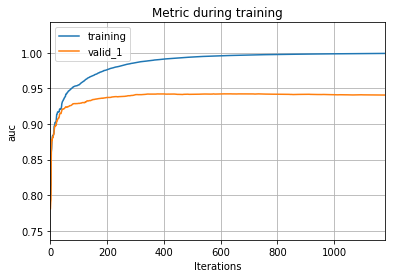

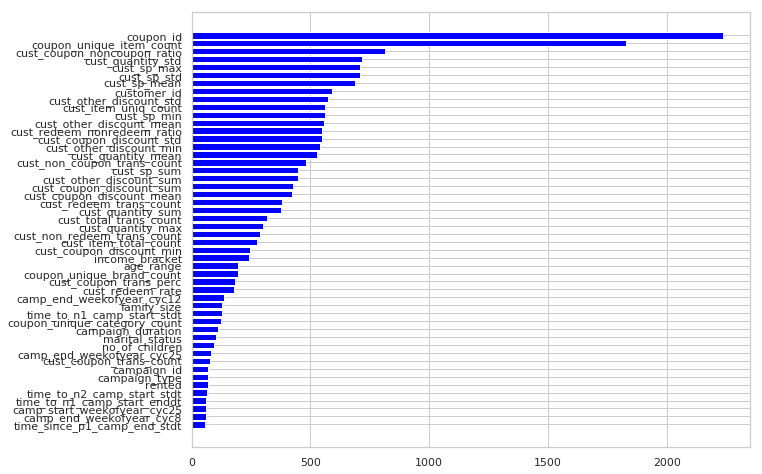

Inside iteration: 1

Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.994265	valid_1's auc: 0.92523
[1000]	training's auc: 0.998641	valid_1's auc: 0.929211
[1500]	training's auc: 0.999655	valid_1's auc: 0.931442
Early stopping, best iteration is:
[1469]	training's auc: 0.999628	valid_1's auc: 0.931693
Plotting metrics recorded during training...


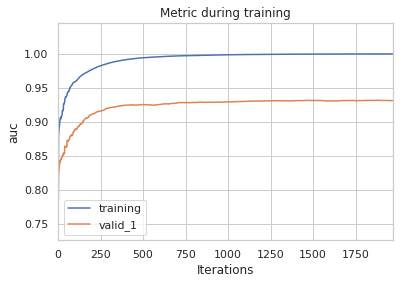

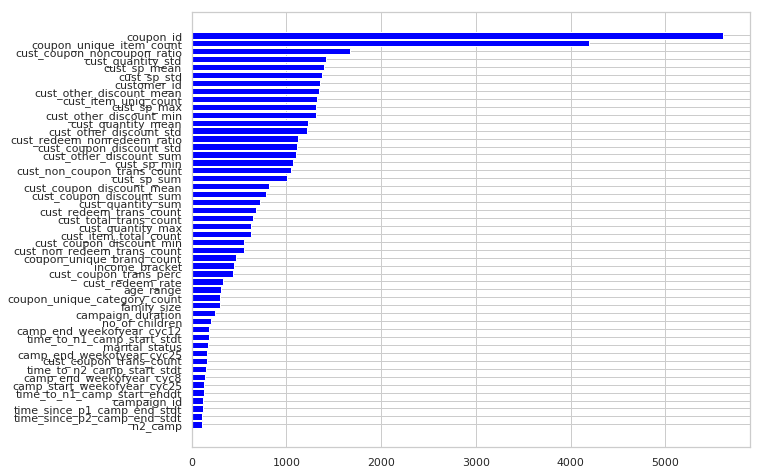

Inside iteration: 2

Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.995484	valid_1's auc: 0.928683
[1000]	training's auc: 0.999059	valid_1's auc: 0.928968
Early stopping, best iteration is:
[616]	training's auc: 0.996942	valid_1's auc: 0.929848
Plotting metrics recorded during training...


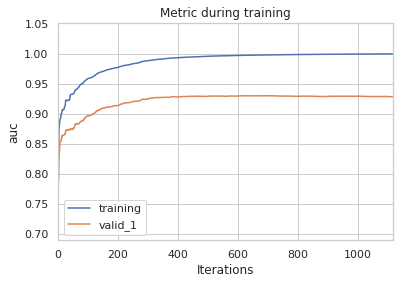

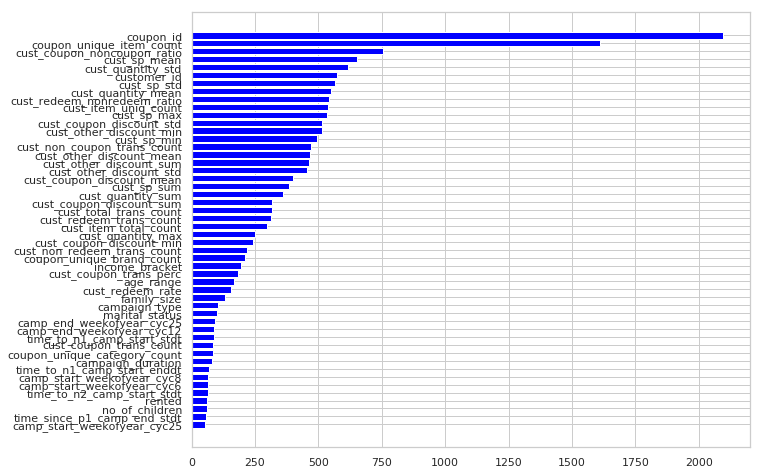

Inside iteration: 3

Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.994489	valid_1's auc: 0.945684
[1000]	training's auc: 0.998652	valid_1's auc: 0.94759
Early stopping, best iteration is:
[849]	training's auc: 0.99803	valid_1's auc: 0.947882
Plotting metrics recorded during training...


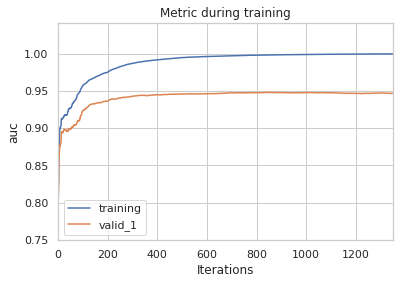

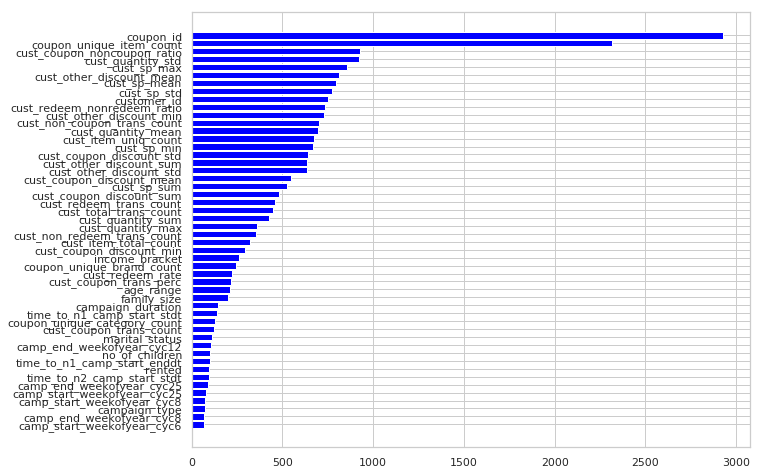

Inside iteration: 4

Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.994889	valid_1's auc: 0.929241
[1000]	training's auc: 0.998703	valid_1's auc: 0.928989
Early stopping, best iteration is:
[556]	training's auc: 0.995679	valid_1's auc: 0.929753
Plotting metrics recorded during training...


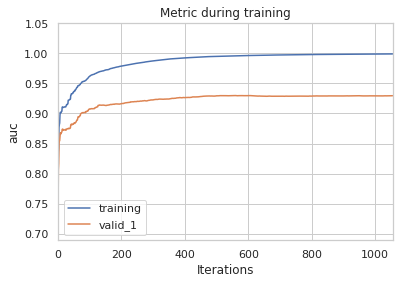

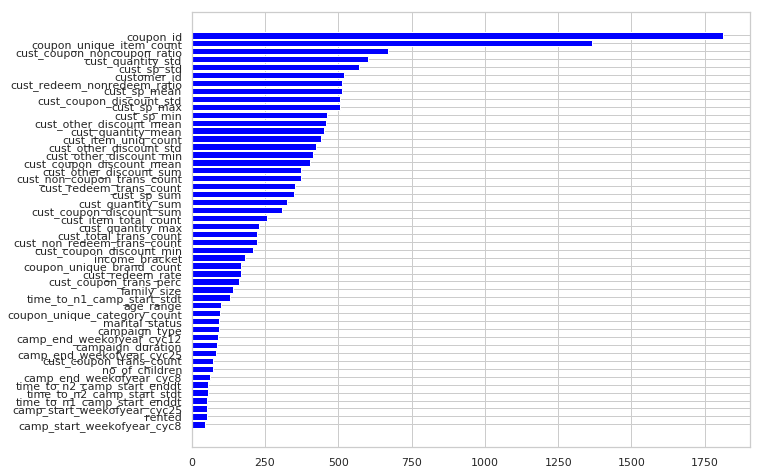

CPU times: user 9min 27s, sys: 9.94 s, total: 9min 37s
Wall time: 2min 31s


In [29]:
%%time
pred_test_full = 0
cv_df = pd.DataFrame()
skf = StratifiedKFold(n_splits=5, random_state=2019)
for idx, (train_index, test_index) in enumerate(skf.split(train_X, train_X["campaign_type"])):
    
    print(f"Inside iteration: {idx}")
    print("======================================")
    print()

    cv_dict={}

    dev_X, val_X = train_X.loc[train_index,:], train_X.loc[test_index,:]
    dev_y, val_y = train_y[train_index], train_y[test_index]
    
    model = runLGB(dev_X,dev_y,val_X,val_y)
    pred_test = model.predict(test_X, num_iteration=model.best_iteration)
    pred_test_full += pred_test
    
    cv_dict['fold_num'] = idx
    cv_dict['train_score'] = model.best_score['training']['auc']
    cv_dict['valid_score'] = model.best_score['valid_1']['auc']
    cv_dict['best_iter'] = model.best_iteration
    cv_dict['dev_camp'] = dev_X["campaign_id"].unique()
    cv_dict['val_camp'] = val_X["campaign_id"].unique()
    
    df = pd.DataFrame([cv_dict], columns=cv_dict.keys())
    cv_df = pd.concat([cv_df, df], axis =0)
    
    plot_lgb_imp(dev_X,model,n=50)
    
pred_test_full /= 5.

In [30]:
print(cv_df["train_score"].mean())
print(cv_df["valid_score"].mean())
cv_df

0.997416027135152
0.9363222508987576


,fold_num,train_score,valid_score,best_iter,dev_camp,val_camp
0,0,0.996801,0.942436,680,"[11, 9, 5, 29, 10, 28, 1, 12, 7, 4, 8, 13, 2, ...","[13, 9, 8, 11, 29, 30, 2, 5, 12, 26, 3, 4, 10,..."
0,1,0.999628,0.931693,1469,"[13, 9, 8, 11, 29, 30, 2, 5, 12, 26, 3, 4, 10,...","[11, 9, 5, 29, 10, 28, 1, 12, 7, 4, 8, 13, 2, ..."
0,2,0.996942,0.929848,616,"[13, 9, 8, 11, 29, 30, 2, 5, 12, 26, 3, 4, 10,...","[30, 8, 26, 13, 11, 5, 29, 9, 28, 10, 12, 4, 7..."
0,3,0.998030,0.947882,849,"[13, 9, 8, 11, 29, 30, 2, 5, 12, 26, 3, 4, 10,...","[8, 13, 30, 26, 10, 2, 1, 7, 3, 28, 11, 12, 29..."
0,4,0.995679,0.929753,556,"[13, 9, 8, 11, 29, 30, 2, 5, 12, 26, 3, 4, 10,...","[8, 13, 26, 30, 11, 12, 29, 9, 5, 2, 27, 10, 7..."


In [31]:
sub=pd.DataFrame()
sub["id"] = test_df["id"]
sub["redemption_status"] = pred_test_full
sub.to_csv("sub32.csv",index=False)

In [32]:
sub.head()

,id,redemption_status
0,3,0.021606
1,4,0.003276
2,5,0.023222
3,8,0.000320
4,10,0.000825
